In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential
import pathlib

2023-05-21 18:23:04.569165: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
batch_size = 8
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  "./small_train",
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  "./small_validation",
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  "./small_test",
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 340 files belonging to 4 classes.
Found 39 files belonging to 4 classes.
Found 40 files belonging to 4 classes.
['Capsicum', 'Carrot', 'Potato', 'Tomato']


2023-05-21 18:23:09.510300: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-05-21 15:03:00.172794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


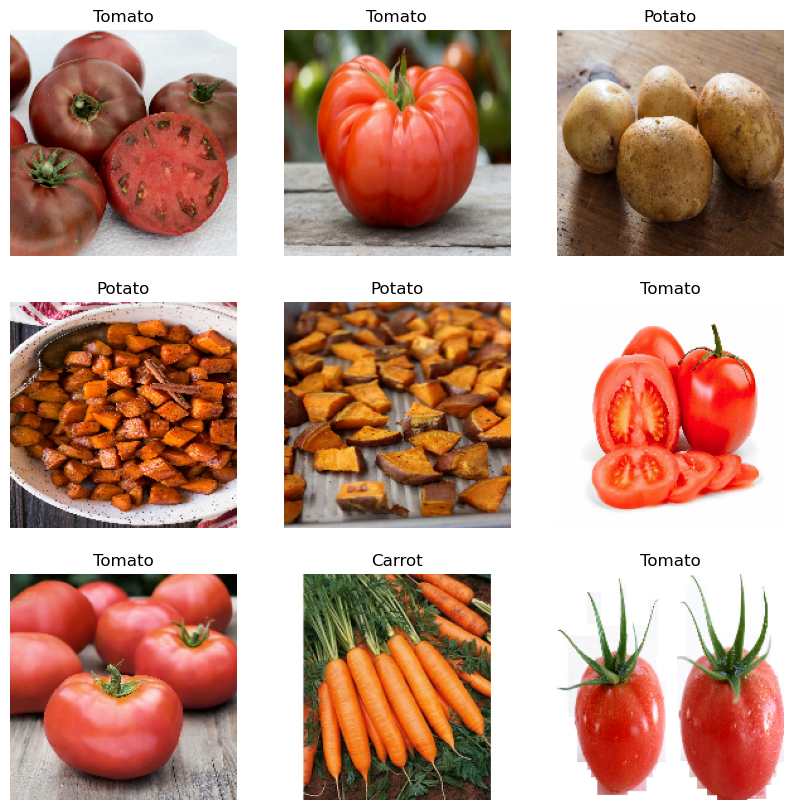

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [4]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

2023-05-21 15:03:39.143050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


(32, 180, 180, 3)
(32,)


In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))



Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-05-21 18:23:14.634673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


0.0 1.0


In [5]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [6]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
43/43 [==============================] - 7s 130ms/step - loss: 1.4370 - accuracy: 0.3971 - val_loss: 1.1543 - val_accuracy: 0.5641
Epoch 2/50
43/43 [==============================] - 5s 111ms/step - loss: 0.9910 - accuracy: 0.6088 - val_loss: 0.5681 - val_accuracy: 0.7436
Epoch 3/50
43/43 [==============================] - 5s 112ms/step - loss: 0.6870 - accuracy: 0.7559 - val_loss: 0.4707 - val_accuracy: 0.7692
Epoch 4/50
43/43 [==============================] - 5s 111ms/step - loss: 0.5008 - accuracy: 0.8088 - val_loss: 0.8780 - val_accuracy: 0.8205
Epoch 5/50
43/43 [==============================] - 5s 111ms/step - loss: 0.4018 - accuracy: 0.8441 - val_loss: 0.1922 - val_accuracy: 0.9744
Epoch 6/50
43/43 [==============================] - 5s 111ms/step - loss: 0.3103 - accuracy: 0.8853 - val_loss: 0.1444 - val_accuracy: 0.9231
Epoch 7/50
43/43 [==============================] - 5s 110ms/step - loss: 0.2352 - accuracy: 0.9118 - val_loss: 0.1185 - val_accuracy: 0.9744
Epoch 

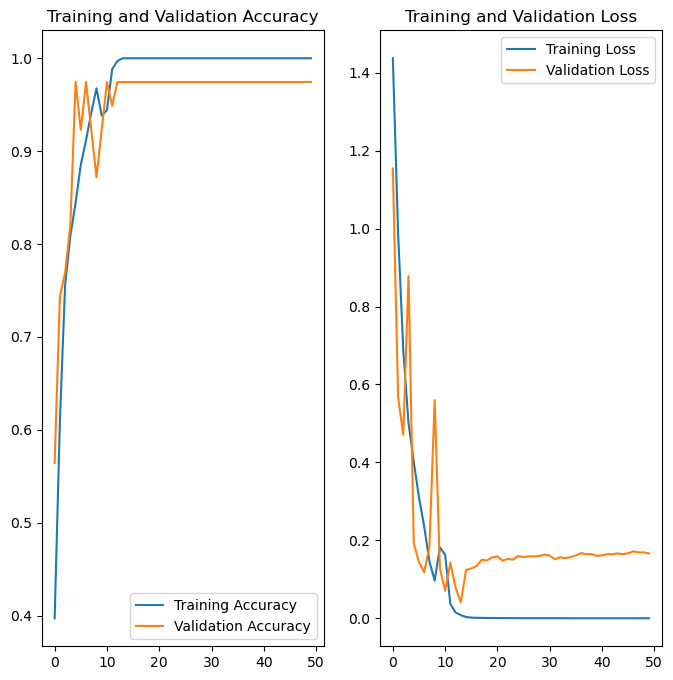

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [8]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 0s 19ms/step - loss: 0.1622 - accuracy: 0.9750


In [31]:
my_tests_ds = tf.keras.utils.image_dataset_from_directory(
  "./my_tests_score_small_no_white",
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

scores = model.evaluate(my_tests_ds)

Found 14 files belonging to 4 classes.
2/2 [==============================] - 0s 17ms/step - loss: 0.8378 - accuracy: 0.7857


In [29]:
img = tf.keras.utils.load_img(
    "./my_tests/my_tomato_5.JPG", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 23ms/step
This image most likely belongs to Carrot with a 96.17 percent confidence.
